# Imports

Works with
```
python 3.7.16 
tf 1.15.0
h5py 3.8.0
deeplift 0.6.12.0
```

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers as layers
from deeplift.conversion import kerasapi_conversion as kc
import sys, h5py, deeplift
print('python', sys.version)
print('tf', tf.__version__)
print('h5py', h5py.__version__)
print('deeplift', deeplift.__version__)

python 3.7.16 (default, Jan 17 2023, 22:20:44) 
[GCC 11.2.0]
tf 1.15.0
h5py 3.8.0
deeplift 0.6.12.0


In [2]:
import deeplift_utils

# Constants

In [28]:
REP = 'out'
MODEL_DIR = 'models'
K = 10 # number of samples for the random reference
N_BEST_GENES = 20
DATA_PATH = '~/data/nabid/pilot2filtered.csv'
MODEL_DIR = 'models/'

In [29]:
rng=np.random.default_rng()

# Data

In [30]:
data = deeplift_utils.get_p53(
    dataset_path=DATA_PATH, labelled=True, normalize='standard', thresh=2e-2, )

2149.50558924675 Read csv
346.63059759140015 remove_cst
479.3825583457947 normalize


In [31]:
data = data[data.allele.isin(['wt','mut'])]
X = data.iloc[:,:-3].to_numpy()
Y = pd.get_dummies(data.allele).astype(int).to_numpy()
X_train, X_test , Y_train, Y_test = train_test_split(X,Y, train_size=0.8)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train , train_size=0.9)

# Training and saving model

In [32]:
model = load_model.make_model(X, shape=[70]*2)
hist = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), 
                 epochs=4
                 )

Train on 2052 samples, validate on 570 samples
Epoch 1/4
2052/2052 [==============================] - 1s 333us/sample - loss: 0.3666 - categorical_accuracy: 0.8333 - val_loss: 0.2233 - val_categorical_accuracy: 0.9211
Epoch 2/4
2052/2052 [==============================] - 1s 270us/sample - loss: 0.2011 - categorical_accuracy: 0.9137 - val_loss: 0.1968 - val_categorical_accuracy: 0.9404
Epoch 3/4
2052/2052 [==============================] - 1s 261us/sample - loss: 0.1655 - categorical_accuracy: 0.9366 - val_loss: 0.2489 - val_categorical_accuracy: 0.9018
Epoch 4/4
2052/2052 [==============================] - 0s 235us/sample - loss: 0.1514 - categorical_accuracy: 0.9405 - val_loss: 0.2286 - val_categorical_accuracy: 0.9228


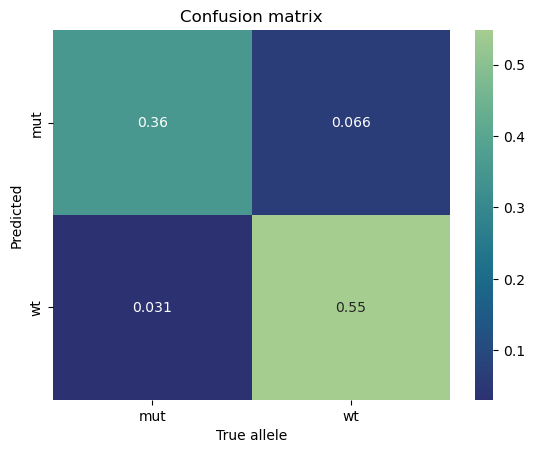

0.9035087719298246


In [33]:
Y_pred = model.predict(X_valid)
Y_pred = pd.DataFrame(np.where(Y_pred>0.5, 1, 0),  columns=['mut', 'wt'])
C = deeplift_utils.confusion_matrix(pd.DataFrame(Y_valid, columns=['mut', 'wt']), Y_pred)
print(C.iloc[0,0]+C.iloc[1,1])

In [34]:
config = model.to_json()
tf.keras.models.save_model(model,f'{MODEL_DIR}/model.h5')
with open(f'{MODEL_DIR}/cfg.json', 'w') as writer:
    writer.write(config)

# Converting model to DeepLIFT

In [35]:
converted = kc.convert_model_from_saved_files(
    f'{MODEL_DIR}/model.h5', json_file=f'{MODEL_DIR}/cfg.json')

nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 1 the preceding linear layer is preact_1 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
For layer 2 the preceding linear layer is preact_2 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case
For layer 3 the preceding linear layer is preact_3 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel


In [36]:
contribs_f = converted.get_target_contribs_func(
                            find_scores_layer_idx=0,
                            target_layer_idx=-2)

# Cells and references

In [37]:
Y_pred = model.predict(X)
# subgroups along the model's prediction
Xpos = X[Y_pred[:,0]>0.5]
Xneg = X[Y_pred[:,0]<0.5]
# sampling along true alleles for the reference. could also do mean over the group
Rpos = lambda n: rng.choice(X[Y[:,0]==1], replace=True, size=n)
Rneg = lambda n: rng.choice(X[Y[:,0]==0], replace=True, size=n)

In [38]:
imp = []
for (ref,i) in zip([Rpos, Rneg], ['+','-']) : 
    sample,j = (Xpos, '+') if i == '-' else (Xneg, '-')
    for ix in range(K):
        A = np.array(contribs_f(task_idx=0,
                                    input_data_list=[sample],
                                    batch_size=10,
                                    progress_update=10000,
                                    input_references_list=[ref(sample.shape[0])])) 
        imp.append([*np.abs(A).mean(axis=0)])
scores = pd.DataFrame(imp, columns=[ *data.columns[:-3]])
scores = scores.mean(axis=0)


Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0


In [39]:
best_genes = scores.sort_values(ascending=False).iloc[:N_BEST_GENES]

In [40]:
scores

ENSG00000241860    0.000399
ENSG00000237491    0.000434
ENSG00000228794    0.000652
ENSG00000225880    0.000207
ENSG00000230699    0.000646
                     ...   
ENSG00000278704    0.000325
ENSG00000276256    0.000422
ENSG00000278384    0.000892
ENSG00000271254    0.000874
ENSG00000278817    0.000886
Length: 12931, dtype: float32

In [41]:
best_genes

ENSG00000054148    0.029521
ENSG00000087088    0.023706
ENSG00000185088    0.020005
ENSG00000078237    0.018736
ENSG00000161513    0.018137
ENSG00000164237    0.017221
ENSG00000136003    0.016521
ENSG00000174775    0.016439
ENSG00000170855    0.015100
ENSG00000196072    0.014838
ENSG00000135679    0.014661
ENSG00000167196    0.014450
ENSG00000168724    0.014342
ENSG00000038427    0.014238
ENSG00000113328    0.014224
ENSG00000122786    0.013951
ENSG00000159388    0.013842
ENSG00000120868    0.013602
ENSG00000160789    0.013136
ENSG00000112249    0.013062
dtype: float32

# Importance results

Text(0.5, 1.0, 'Contribution scores distribution')

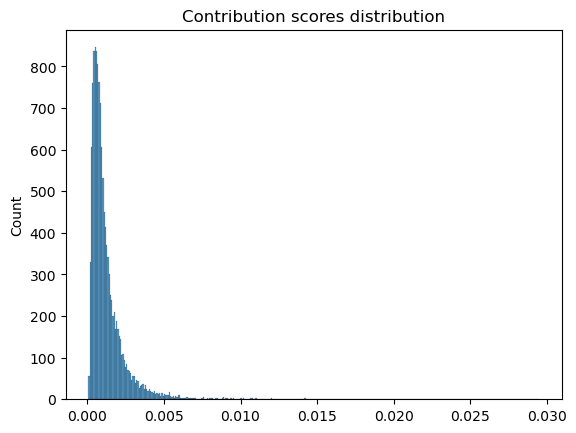

In [42]:
sns.histplot(scores)
# plt.yscale('log')
plt.title('Contribution scores distribution')


In [43]:
df = data[best_genes.index].copy() #silence warning
df['allele'] = data['allele'] 
df = df.melt(value_name='Expression', var_name='gene', id_vars='allele')

In [44]:
df

,allele,gene,Expression
0,mut,ENSG00000054148,-0.386866
1,wt,ENSG00000054148,-1.129578
2,wt,ENSG00000054148,0.541523
3,mut,ENSG00000054148,0.912879
4,mut,ENSG00000054148,-0.386866
...,...,...,...
56995,wt,ENSG00000112249,-0.347240
56996,wt,ENSG00000112249,0.234060
56997,mut,ENSG00000112249,-0.347240
56998,wt,ENSG00000112249,1.977960


<AxesSubplot:xlabel='gene', ylabel='Expression'>

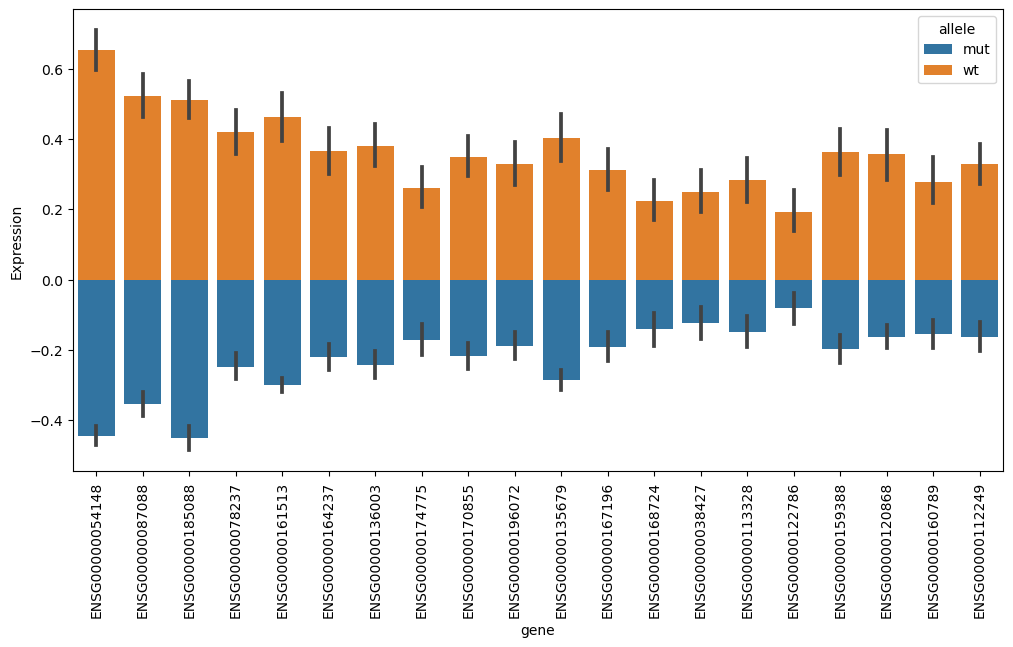

In [45]:
plt.gcf().set_size_inches([12,6])
plt.xticks(rotation=90)
sns.barplot(data=df, hue='allele', x='gene', y='Expression', order=best_genes.index, dodge=False)
# plt.savefig(TEMP_PATH)

In [46]:
df

,allele,gene,Expression
0,mut,ENSG00000054148,-0.386866
1,wt,ENSG00000054148,-1.129578
2,wt,ENSG00000054148,0.541523
3,mut,ENSG00000054148,0.912879
4,mut,ENSG00000054148,-0.386866
...,...,...,...
56995,wt,ENSG00000112249,-0.347240
56996,wt,ENSG00000112249,0.234060
56997,mut,ENSG00000112249,-0.347240
56998,wt,ENSG00000112249,1.977960


# Saving results

In [47]:
best_genes.to_csv(f'{REP}/{N_BEST_GENES}_best_genes.csv',header=['score'] )